In [1]:
import torch
from torch import nn

from torchvision import transforms, datasets
from torchvision.utils import make_grid

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchstat import stat

from tqdm import tqdm, trange
import wandb

## 定义生成器

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim, im_chan, hidden_dim=64):
        super().__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 4*hidden_dim, 4, 2),  # B, 4*hidden_dim, 4, 4
            nn.BatchNorm2d(4*hidden_dim),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, 1),  # B, 2*hidden_dim, 7, 7
            nn.BatchNorm2d(2*hidden_dim),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 3, 2),  # B, hidden_dim, 15, 15
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_dim, im_chan, 4, 2),  # B, im_chan, 32, 32
            nn.Tanh()
        )

    def forward(self, noise):
        noise = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(noise)

## 定义辨别器

In [3]:
class Discriminator(nn.Module):
    def __init__(self, im_chan, hidden_dim=16):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(im_chan, hidden_dim, 4, 2),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_dim, hidden_dim*2, 4, 2),
            nn.BatchNorm2d(hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(hidden_dim*2, 1, 5, 2)
        )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## 数据集可视化

Files already downloaded and verified


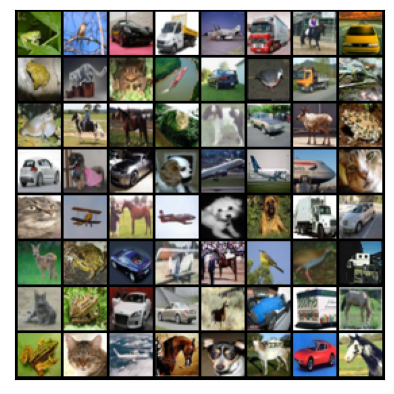

In [2]:
BATCH_SIZE = 64
trans = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.CIFAR10('./data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
data, label = next(iter(data_loader))
data_display = transforms.ToPILImage()(make_grid(data, nrow=8))
plt.xticks([])
plt.yticks([])
plt.imshow(data_display)

## 初始化训练设置

In [5]:
BATCH_SIZE = 128
dataset = datasets.CIFAR10('./data/', train=True, transform=trans, download=True)
# dataset = datasets.MNIST('./data/', train=True, transform=trans, download=True)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
criterion = nn.BCEWithLogitsLoss()
latent_dim = 100
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f"device:{device}")

Files already downloaded and verified
device:cuda:0


In [6]:
gen = Generator(latent_dim, 3, hidden_dim=256).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator(3, hidden_dim=32).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## 定义功能性函数

In [7]:
def display_images(image_tensor, num_images=64, size=(1, 32, 32)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=8, normalize=True)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [8]:
def random_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim)

## 定义生成器损失和辨别器损失

In [9]:
def gen_loss(gen, disc, num_images, latent_dim, device, criterion):
    noise = random_noise(num_images, latent_dim).to(device)
    gen_img = gen(noise)

    disc_gen = disc(gen_img)
    gen_loss = criterion(disc_gen, torch.ones_like(disc_gen))

    return gen_loss

def disc_loss(gen, disc, real_images, num_images, latent_dim, device, criterion):
    noise = random_noise(num_images, latent_dim).to(device)
    img_gen = gen(noise)

    disc_gen = disc(img_gen.detach())
    disc_real = disc(real_images)

    gen_loss = criterion(disc_gen, torch.zeros_like(disc_gen))
    disc_loss = criterion(disc_real, torch.ones_like(disc_real))

    disc_loss = ((gen_loss + disc_loss) / 2).mean()

    return disc_loss

In [10]:
wandb.init(project="Gan", name="test", entity="ruizhuo_xu")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ruizhuo_xu. Use `wandb login --relogin` to force relogin


## 训练

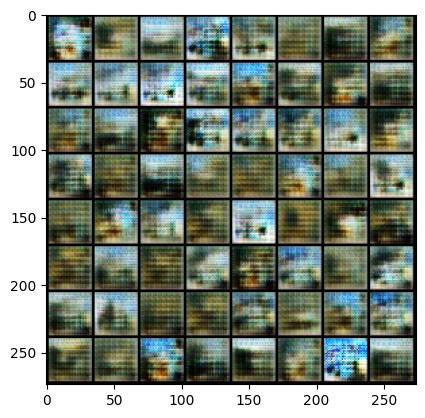

wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.


In [11]:
num_epochs = 100
steps_per_epoch = len(data_loader)
process_bar = tqdm(total=steps_per_epoch)
step = 0
for epoch in range(num_epochs):
    D_loss_total = 0
    G_loss_total = 0
    for i, (images, _) in enumerate(data_loader):
        num_images = len(images)
        real_images = images.to(device)
        
        disc_opt.zero_grad()
        D_loss = disc_loss(gen, disc, real_images, num_images, latent_dim, device, criterion)
        D_loss.backward()
        D_loss_total += D_loss.item()
        disc_opt.step()

        gen_opt.zero_grad()
        G_loss = gen_loss(gen, disc, num_images, latent_dim, device, criterion)
        G_loss.backward()
        G_loss_total += G_loss.item()
        gen_opt.step()

        wandb.log(
            {
                "D_loss_step": D_loss.item(),
                "G_loss_step": G_loss.item()
            },
            step
        )
        step += 1
        process_bar.set_description(desc=f"Epoch:{epoch+1}/{num_epochs} Training:{i + 1}/{len(data_loader)}")
        process_bar.update()
    process_bar.reset()
    wandb.log(
        {
            "D_loss_epoch": D_loss_total / len(data_loader),
            "G_loss_epoch": G_loss_total / len(data_loader),
            "epoch": epoch + 1
        },
        step
    )
    with torch.no_grad():
        noise = random_noise(64, latent_dim).to(device)
        img = gen(noise)
        img_log = make_grid(img, nrow=8, normalize=True)
        wandb.log(
            {
                "gen_img": wandb.Image(img_log)        
            },
            step
        )
        clear_output(wait=True)
        display_images(img, size=(3, 32, 32))

In [13]:
process_bar.close()
wandb.finish()

  0%|          | 0/50000 [02:41<?, ?it/s]


wandb: Network error (TransientError), entering retry loop.
wandb: ERROR Control-C detected -- Run data was not synced


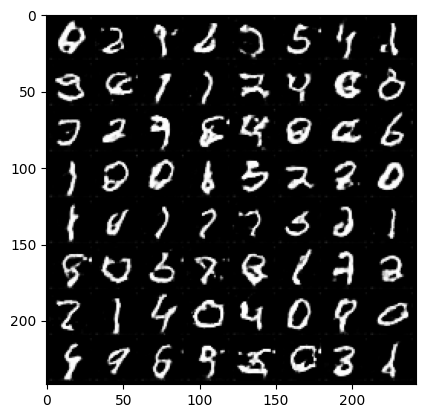

Epoch:12/100 Training:400/469:  85%|████████▌ | 400/469 [00:55<00:06, 11.38it/s]

In [12]:
plt.imshow(transforms.ToPILImage()(img_log), cmap='gray')